<a href="https://colab.research.google.com/github/HFooladi/GNNs-For-Chemists/blob/main/notebooks/04_GNN_GCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Graph Convolutional Networks (GCN) Tutorial for Chemists and Pharmacists

## Table of Contents
1. [Introduction](#introduction)
2. [Setup and Installation](#setup-and-installation)
3. [Understanding Molecular Graphs](#understand-graph)
4. [Graph Convolutional Networks: Basic Concepts](#gcn-basics)
5. [Implementing a Basic GCN ](#implement-gcn)
6. [Exploring Different Pooling Methods](#explore-pooling)
7. [Demonstrating the Differences Between Pooling Methods on Real Molecules](#demonstrate-pooling)
8. [Exploring the Effect of Network Depth](#gcn-depth)
9. [Understanding and Implementing Skip Connections](#skip-connection)
10. [Visualizing Node Feature Learning](#node-feature-learning)
11. [Conclusion and Comprehensive Findings](#conclusion)
12. [Additional Resources and References](#resources)


## 1. Introduction  <a name="introduction"></a>

Graph Convolutional Networks (GCNs) are a powerful class of neural networks designed to work directly on graph-structured data. In chemistry and drug discovery, molecules are naturally represented as graphs, with atoms as nodes and bonds as edges, making GCNs particularly valuable for tasks like molecular property prediction and drug design.

This notebook provides a step-by-step exploration of GCNs with a focus on:
1. How different pooling methods (max, sum, mean) affect results
2. The impact of network depth (increasing the number of layers)
3. The effect of adding skip connections to the architecture

## 2. Setup and Installation <a name="setup-and-installation"></a>

First, let's install the necessary packages:

In [ ]:
#@title Intstall necessary libraries
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install -q rdkit
!pip install -q networkx

2.6.0+cu124
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 11.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 27.4 MB/s eta 0:00:00


In [ ]:
#@title Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_add_pool, global_max_pool, global_mean_pool
from torch_geometric.data import Data
from torch_geometric.datasets import MoleculeNet
from torch_geometric.utils import to_networkx

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import networkx as nx
from rdkit import Chem
from rdkit.Chem import Draw, AllChem
from rdkit.Chem.Draw import rdMolDraw2D
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import io
from PIL import Image
import random
from IPython.display import HTML

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## 3. Understanding Molecular Graphs <a name="understand-graph"></a>

Let's start by visualizing molecules as graphs, which is essential for understanding how GCNs process molecular data.


Aspirin


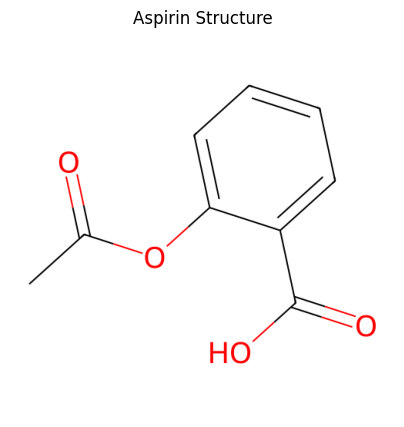

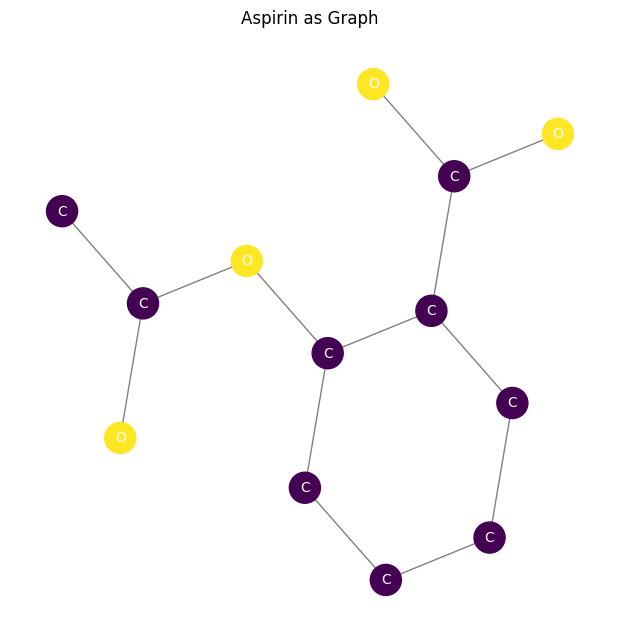


Paracetamol


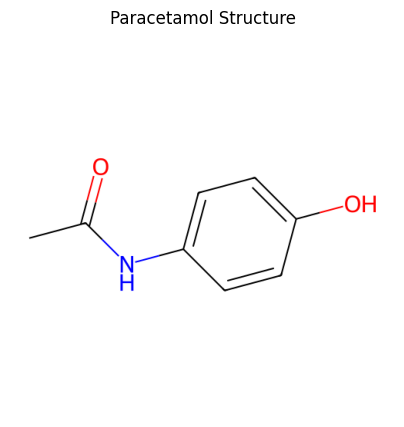

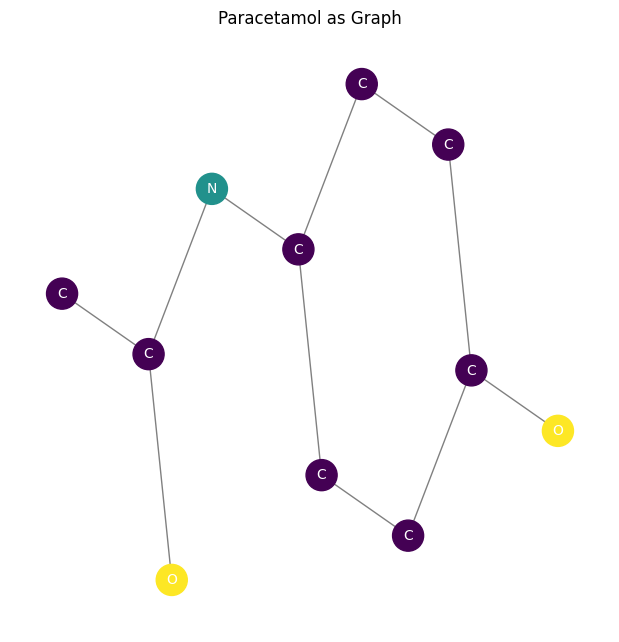


Ibuprofen


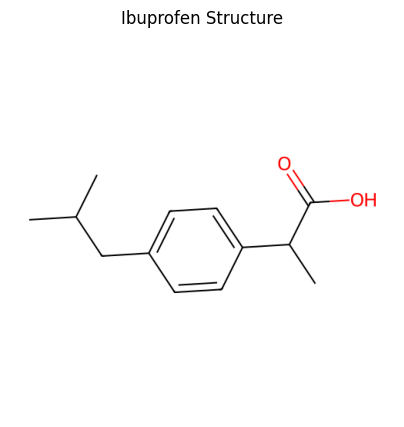

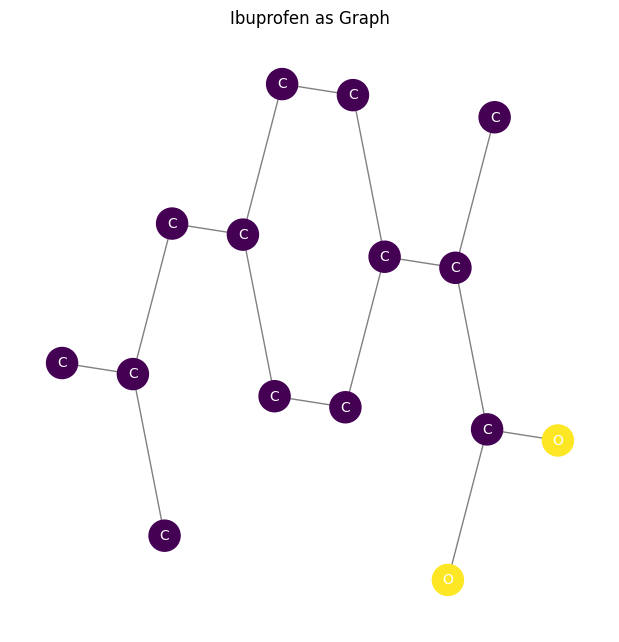

In [ ]:
def mol_to_graph(smiles):
    """Convert a SMILES string to a PyTorch Geometric Data object"""
    mol = Chem.MolFromSmiles(smiles)

    # Get node features (atomic numbers as initial features)
    node_features = []
    for atom in mol.GetAtoms():
        features = [
            atom.GetAtomicNum(),
            atom.GetFormalCharge(),
            atom.GetNumExplicitHs(),
            atom.GetNumImplicitHs(),
            int(atom.GetIsAromatic()),
            atom.GetDegree()
        ]
        node_features.append(features)

    x = torch.tensor(node_features, dtype=torch.float)

    # Get edge indices
    edge_indices = []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        # Add edges in both directions
        edge_indices.append([i, j])
        edge_indices.append([j, i])

    edge_index = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()

    # Get edge features (bond types)
    edge_features = []
    for bond in mol.GetBonds():
        # Add features for both directions
        features = [bond.GetBondTypeAsDouble()]
        edge_features.append(features)
        edge_features.append(features)

    edge_attr = torch.tensor(edge_features, dtype=torch.float)

    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, smiles=smiles)

def visualize_molecule(smiles, title="Molecule"):
    """Visualize a molecule using RDKit"""
    mol = Chem.MolFromSmiles(smiles)
    AllChem.Compute2DCoords(mol)

    # Draw molecule
    fig, ax = plt.subplots(figsize=(5, 5))
    drawer = rdMolDraw2D.MolDraw2DCairo(500, 500)
    drawer.DrawMolecule(mol)
    drawer.FinishDrawing()
    img = drawer.GetDrawingText()

    # Convert the image data to a PIL Image
    pil_image = Image.open(io.BytesIO(img))

    # Display the image
    plt.imshow(pil_image)
    plt.axis('off')
    plt.title(title)
    plt.show()

def visualize_molecular_graph(smiles, title="Molecular Graph"):
    """Visualize a molecule as a graph using NetworkX"""
    mol = Chem.MolFromSmiles(smiles)
    AllChem.Compute2DCoords(mol)

    data = mol_to_graph(smiles)
    G = to_networkx(data, to_undirected=True)

    # Get the 2D coordinates from RDKit
    pos = {}
    for i, atom in enumerate(mol.GetAtoms()):
        pos[i] = mol.GetConformer().GetAtomPosition(i)
        pos[i] = (pos[i].x, -pos[i].y)  # Flip y for better visualization

    plt.figure(figsize=(6, 6))

    # Get atom labels
    atom_labels = {i: atom.GetSymbol() for i, atom in enumerate(mol.GetAtoms())}

    # Get atom features for node coloring
    atom_features = [atom.GetAtomicNum() for atom in mol.GetAtoms()]

    # Draw the graph
    nx.draw(G, pos,
            labels=atom_labels,
            with_labels=True,
            node_color=atom_features,
            cmap=plt.cm.viridis,
            node_size=500,
            font_size=10,
            font_color='white',
            edge_color='gray')

    plt.title(title)
    plt.axis('off')
    plt.show()

# Example molecules
example_molecules = {
    "Aspirin": "CC(=O)OC1=CC=CC=C1C(=O)O",
    "Paracetamol": "CC(=O)NC1=CC=C(C=C1)O",
    "Ibuprofen": "CC(C)CC1=CC=C(C=C1)C(C)C(=O)O"
}

# Visualize each molecule
for name, smiles in example_molecules.items():
    print(f"\n{name}")
    visualize_molecule(smiles, f"{name} Structure")
    visualize_molecular_graph(smiles, f"{name} as Graph")

## 4. Graph Convolutional Networks: Basic Concepts <a name="gcn-basics"></a>

Now that we understand how molecules are represented as graphs, let's explore the basic concepts of Graph Convolutional Networks.

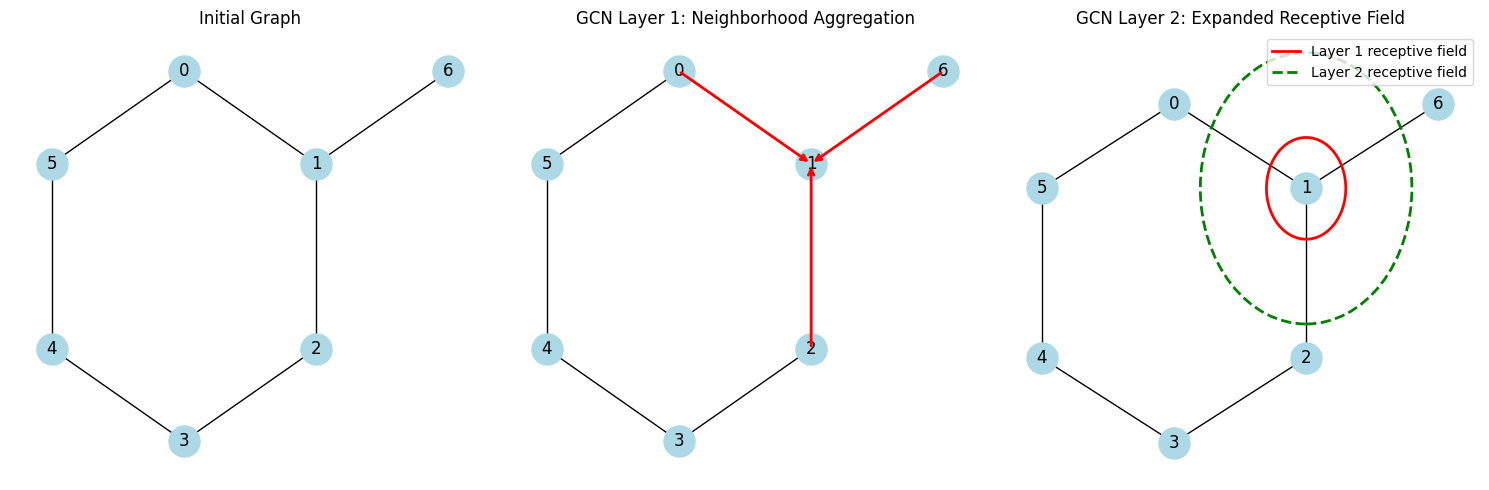

In [ ]:
# Create a simple visualization of GCN message passing
def visualize_gcn_message_passing():
    """Create a visual explanation of GCN message passing"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Create a simple molecular graph for illustration
    G = nx.Graph()
    G.add_nodes_from(range(7))

    # Define edges for a simple molecule (like benzene with a side chain)
    edges = [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 0), (1, 6)]
    G.add_edges_from(edges)

    # Define positions
    pos = {
        0: (0, 1),
        1: (1, 0.5),
        2: (1, -0.5),
        3: (0, -1),
        4: (-1, -0.5),
        5: (-1, 0.5),
        6: (2, 1)
    }

    # Initial state - just the graph
    ax = axes[0]
    nx.draw(G, pos,
            node_color='lightblue',
            node_size=500,
            with_labels=True,
            font_size=12,
            font_color='black',
            ax=ax)
    ax.set_title("Initial Graph")

    # First GCN layer - gather information from neighbors
    ax = axes[1]
    nx.draw(G, pos,
            node_color='lightblue',
            node_size=500,
            with_labels=True,
            font_size=12,
            font_color='black',
            ax=ax)

    # Add arrows to show information flow
    central_node = 1
    for neighbor in [0, 2, 6]:
        ax.annotate("",
                  xy=pos[central_node],
                  xytext=pos[neighbor],
                  arrowprops=dict(arrowstyle="->", color="red", lw=2))

    ax.set_title("GCN Layer 1: Neighborhood Aggregation")

    # Second GCN layer - expanded neighborhood
    ax = axes[2]
    nx.draw(G, pos,
            node_color='lightblue',
            node_size=500,
            with_labels=True,
            font_size=12,
            font_color='black',
            ax=ax)

    # Draw circles to show the receptive field
    circle1 = plt.Circle(pos[central_node], 0.3, color='red', fill=False, linestyle='-', linewidth=2)
    circle2 = plt.Circle(pos[central_node], 0.8, color='green', fill=False, linestyle='--', linewidth=2)
    ax.add_patch(circle1)
    ax.add_patch(circle2)

    # Add a legend
    ax.plot([], [], color='red', linestyle='-', linewidth=2, label='Layer 1 receptive field')
    ax.plot([], [], color='green', linestyle='--', linewidth=2, label='Layer 2 receptive field')
    ax.legend(loc='upper right')

    ax.set_title("GCN Layer 2: Expanded Receptive Field")

    plt.tight_layout()
    plt.show()

visualize_gcn_message_passing()

## 5. Implementing a Basic GCN <a name="implement-gcn"></a>

Let's implement a basic GCN for molecular property prediction:

In [ ]:
class BasicGCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers=2):
        super(BasicGCN, self).__init__()

        # Input layer
        self.conv1 = GCNConv(in_channels, hidden_channels)

        # Hidden layers
        self.convs = nn.ModuleList()
        for _ in range(num_layers - 1):
            self.convs.append(GCNConv(hidden_channels, hidden_channels))

        # Output layer
        self.lin1 = nn.Linear(hidden_channels, hidden_channels)
        self.lin2 = nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index, batch):
        # First GCN layer
        x = self.conv1(x, edge_index)
        x = F.relu(x)

        # Additional GCN layers
        for conv in self.convs:
            x = conv(x, edge_index)
            x = F.relu(x)

        # Global pooling (default: mean)
        x = global_mean_pool(x, batch)

        # MLP for final prediction
        x = F.relu(self.lin1(x))
        x = self.lin2(x)

        return x

# Create a simple model to demonstrate
sample_data = mol_to_graph(example_molecules["Aspirin"])
print(f"Node features: {sample_data.x.shape}")
model = BasicGCN(sample_data.x.shape[1], 64, 1)
print(model)

Node features: torch.Size([13, 6])
BasicGCN(
  (conv1): GCNConv(6, 64)
  (convs): ModuleList(
    (0): GCNConv(64, 64)
  )
  (lin1): Linear(in_features=64, out_features=64, bias=True)
  (lin2): Linear(in_features=64, out_features=1, bias=True)
)


## 6. Exploring Different Pooling Methods <a name="explore-pooling"></a>

Now let's compare the effect of different pooling methods: max, sum, and mean pooling.

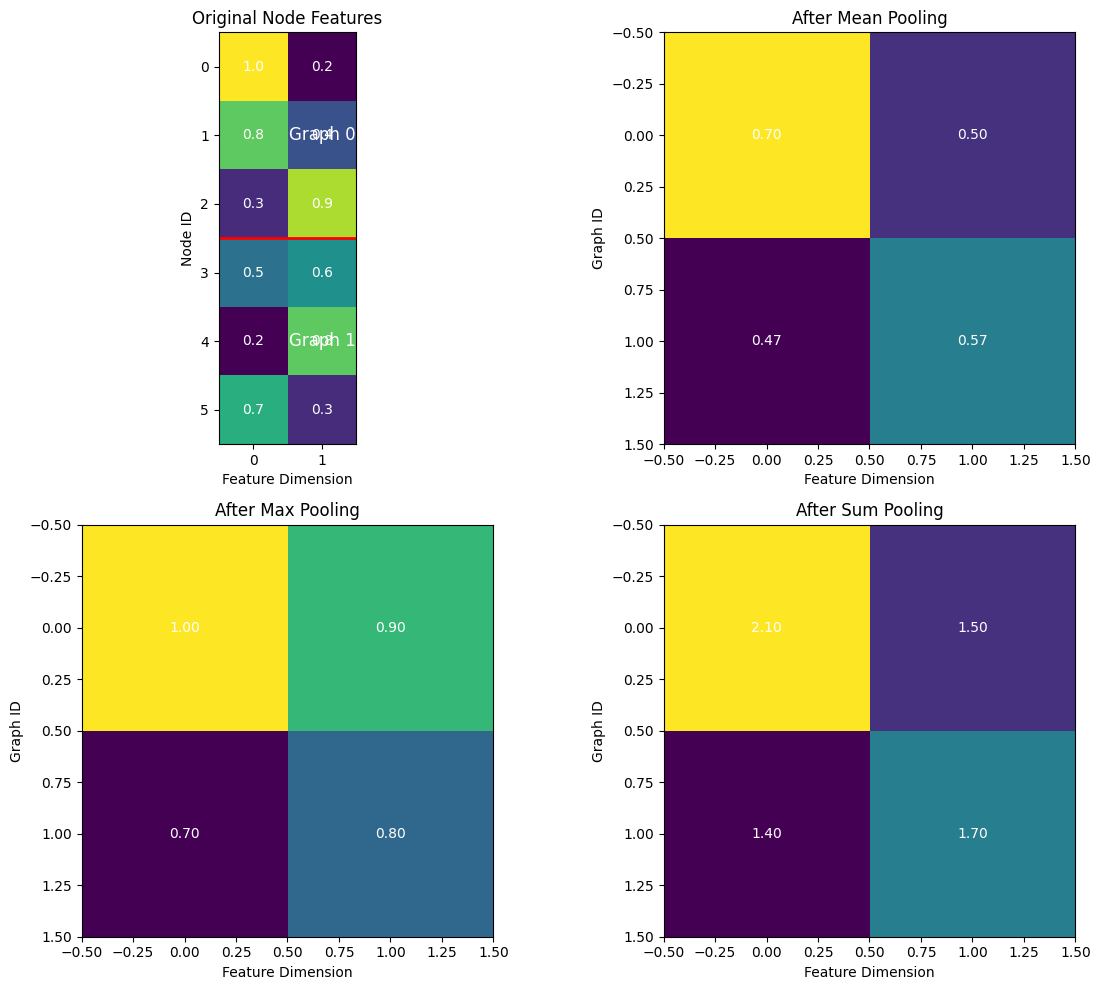

In [ ]:
class GCNWithPooling(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, pooling_method='mean'):
        super(GCNWithPooling, self).__init__()

        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)

        self.lin1 = nn.Linear(hidden_channels, hidden_channels)
        self.lin2 = nn.Linear(hidden_channels, out_channels)

        # Set pooling method
        self.pooling_method = pooling_method

    def forward(self, x, edge_index, batch):
        # GCN layers
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))

        # Apply the specified pooling method
        if self.pooling_method == 'max':
            x = global_max_pool(x, batch)
        elif self.pooling_method == 'sum':
            x = global_add_pool(x, batch)
        else:  # Default to mean
            x = global_mean_pool(x, batch)

        # Final MLP
        x = F.relu(self.lin1(x))
        x = self.lin2(x)

        return x

def visualize_pooling_operations():
    """Visualize how different pooling operations work on node features"""
    # Create a simple example
    node_features = torch.tensor([
        [1.0, 0.2],
        [0.8, 0.4],
        [0.3, 0.9],
        [0.5, 0.6],
        [0.2, 0.8],
        [0.7, 0.3]
    ], dtype=torch.float)

    # Batch indicator: first 3 nodes belong to graph 0, next 3 to graph 1
    batch = torch.tensor([0, 0, 0, 1, 1, 1], dtype=torch.long)

    # Apply different pooling operations
    mean_pooled = global_mean_pool(node_features, batch)
    max_pooled = global_max_pool(node_features, batch)
    sum_pooled = global_add_pool(node_features, batch)

    # Create visualization
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # Original node features
    ax = axes[0, 0]
    ax.imshow(node_features.numpy(), cmap='viridis')
    ax.set_title("Original Node Features")
    ax.set_xlabel("Feature Dimension")
    ax.set_ylabel("Node ID")

    for i in range(len(node_features)):
        graph_id = batch[i].item()
        for j in range(node_features.size(1)):
            ax.text(j, i, f"{node_features[i, j]:.1f}",
                   ha="center", va="center", color="white")

    # Add dividing line between graphs
    ax.axhline(y=2.5, color='red', linestyle='-', linewidth=2)
    ax.text(node_features.size(1) - 0.5, 1, "Graph 0", ha="right", va="center", color="white", fontsize=12)
    ax.text(node_features.size(1) - 0.5, 4, "Graph 1", ha="right", va="center", color="white", fontsize=12)

    # Mean pooling
    ax = axes[0, 1]
    ax.imshow(mean_pooled.numpy(), cmap='viridis')
    ax.set_title("After Mean Pooling")
    ax.set_xlabel("Feature Dimension")
    ax.set_ylabel("Graph ID")

    for i in range(mean_pooled.size(0)):
        for j in range(mean_pooled.size(1)):
            ax.text(j, i, f"{mean_pooled[i, j]:.2f}",
                   ha="center", va="center", color="white")

    # Max pooling
    ax = axes[1, 0]
    ax.imshow(max_pooled.numpy(), cmap='viridis')
    ax.set_title("After Max Pooling")
    ax.set_xlabel("Feature Dimension")
    ax.set_ylabel("Graph ID")

    for i in range(max_pooled.size(0)):
        for j in range(max_pooled.size(1)):
            ax.text(j, i, f"{max_pooled[i, j]:.2f}",
                   ha="center", va="center", color="white")

    # Sum pooling
    ax = axes[1, 1]
    ax.imshow(sum_pooled.numpy(), cmap='viridis')
    ax.set_title("After Sum Pooling")
    ax.set_xlabel("Feature Dimension")
    ax.set_ylabel("Graph ID")

    for i in range(sum_pooled.size(0)):
        for j in range(sum_pooled.size(1)):
            ax.text(j, i, f"{sum_pooled[i, j]:.2f}",
                   ha="center", va="center", color="white")

    plt.tight_layout()
    plt.show()

# Visualize how the different pooling operations work
visualize_pooling_operations()

## 7. Demonstrating the Differences Between Pooling Methods on Real Molecules <a name="demonstrate-pooling"></a>

Let's understand how different pooling methods impact results for molecular property prediction:

Loading ESOL dataset (water solubility data)...
Dataset loaded: 1128 molecules
Train: 902, Validation: 113, Test: 113

Training model with Mean Pooling...
Epoch   5: Train Loss = 4.0908, Val Loss = 4.6900
Epoch  10: Train Loss = 3.8524, Val Loss = 4.3051
Epoch  15: Train Loss = 3.6162, Val Loss = 4.0199
Epoch  20: Train Loss = 3.2956, Val Loss = 3.6880
Epoch  25: Train Loss = 3.0516, Val Loss = 3.2496
Epoch  30: Train Loss = 2.7487, Val Loss = 2.9522
Epoch  35: Train Loss = 2.4461, Val Loss = 3.1945
Epoch  40: Train Loss = 2.2195, Val Loss = 2.4002
Epoch  45: Train Loss = 2.1410, Val Loss = 2.2638
Epoch  50: Train Loss = 1.8127, Val Loss = 3.0371

Training model with Max Pooling...
Epoch   5: Train Loss = 3.9507, Val Loss = 4.4901
Epoch  10: Train Loss = 3.5277, Val Loss = 3.7460
Epoch  15: Train Loss = 3.2022, Val Loss = 3.4869
Epoch  20: Train Loss = 3.0346, Val Loss = 2.9813
Epoch  25: Train Loss = 2.5888, Val Loss = 2.6085
Epoch  30: Train Loss = 2.5342, Val Loss = 2.7866
Epoch  35

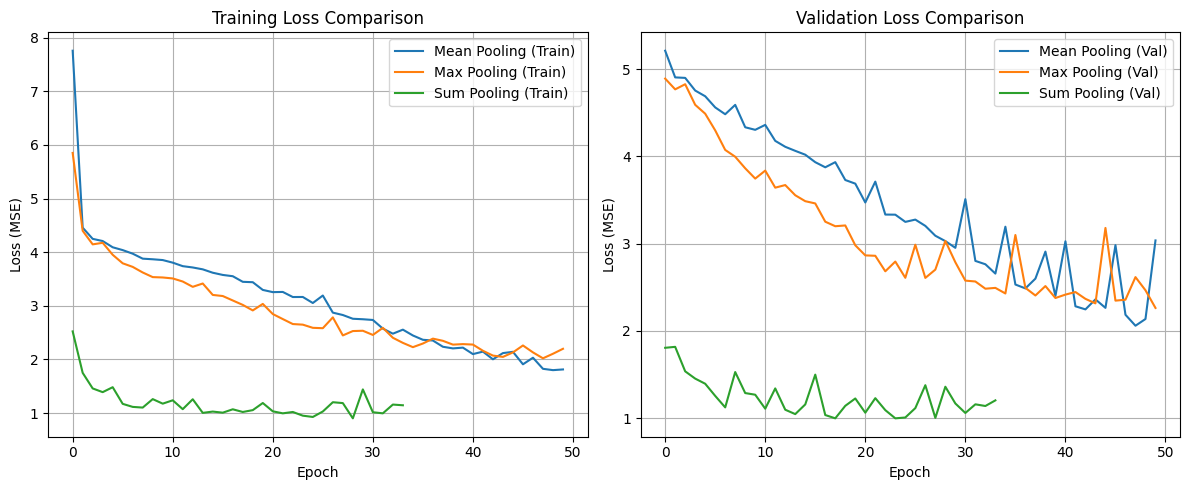

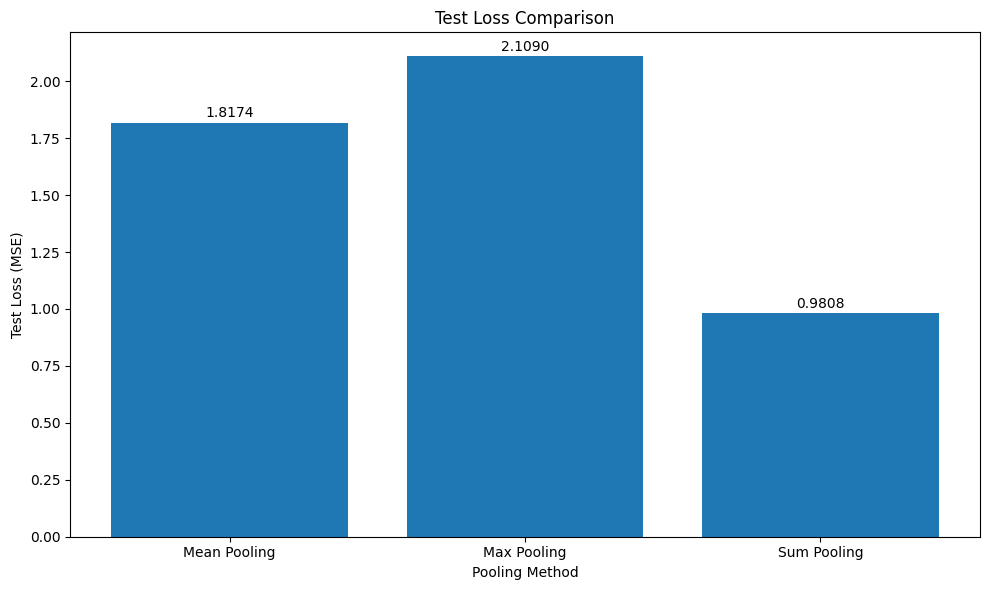

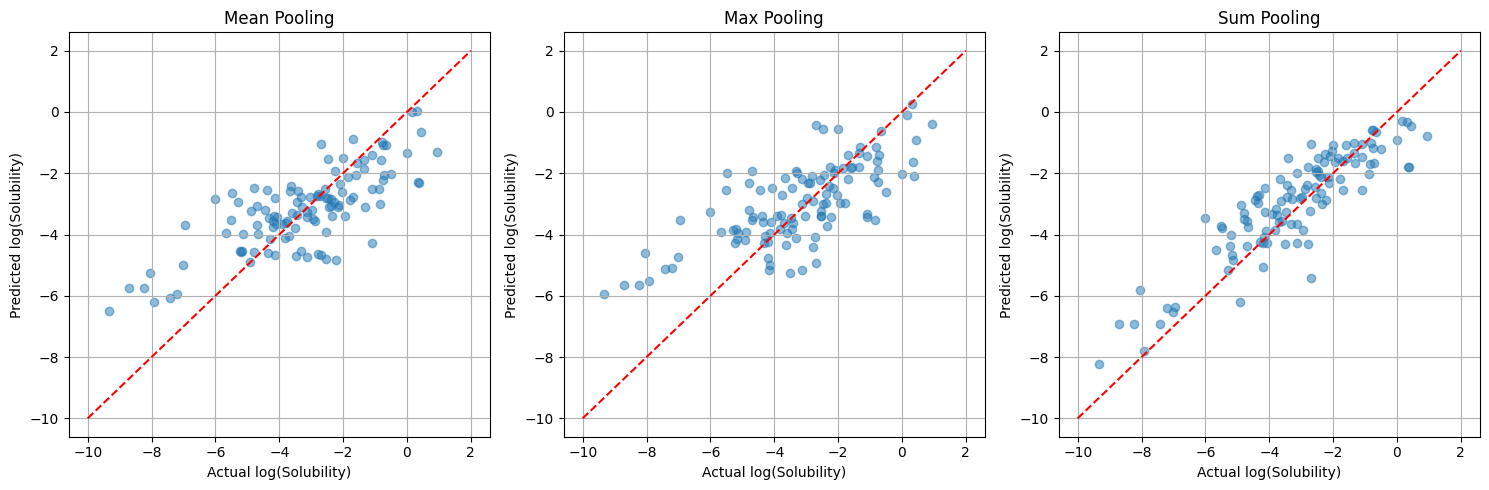

In [ ]:
# Load a dataset from MoleculeNet
print("Loading ESOL dataset (water solubility data)...")
dataset = MoleculeNet(root='data', name='ESOL')
print(f"Dataset loaded: {len(dataset)} molecules")

# Split the dataset
torch.manual_seed(42)
indices = torch.randperm(len(dataset))
train_idx = indices[:int(0.8 * len(dataset))]
val_idx = indices[int(0.8 * len(dataset)):int(0.9 * len(dataset))]
test_idx = indices[int(0.9 * len(dataset)):]

train_dataset = dataset[train_idx]
val_dataset = dataset[val_idx]
test_dataset = dataset[test_idx]

print(f"Train: {len(train_dataset)}, Validation: {len(val_dataset)}, Test: {len(test_dataset)}")

# Create data loaders
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Function to train and evaluate models
def train_and_evaluate(model, optimizer, criterion, train_loader, val_loader, test_loader, epochs=50, early_stopping=True):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience = 10
    patience_counter = 0

    for epoch in range(1, epochs+1):
        # Training
        model.train()
        train_loss = 0
        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data.x.float(), data.edge_index, data.batch)
            loss = criterion(out, data.y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * data.num_graphs

        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data in val_loader:
                data = data.to(device)
                out = model(data.x.float(), data.edge_index, data.batch)
                loss = criterion(out, data.y)
                val_loss += loss.item() * data.num_graphs

        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        # Print progress
        if epoch % 5 == 0:
            print(f"Epoch {epoch:3d}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")

        # Check for early stopping
        if early_stopping:
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                # Save the best model
                torch.save(model.state_dict(), 'best_model.pt')
            else:
                patience_counter += 1

            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch}")
                break

    # Load the best model if using early stopping
    if early_stopping:
        model.load_state_dict(torch.load('best_model.pt'))

    # Evaluate on test set
    model.eval()
    test_loss = 0
    test_preds = []
    test_targets = []

    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            out = model(data.x.float(), data.edge_index, data.batch)
            loss = criterion(out, data.y)
            test_loss += loss.item() * data.num_graphs
            test_preds.append(out.cpu())
            test_targets.append(data.y.cpu())

    test_loss /= len(test_loader.dataset)
    test_preds = torch.cat(test_preds, dim=0)
    test_targets = torch.cat(test_targets, dim=0)

    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'test_loss': test_loss,
        'test_preds': test_preds,
        'test_targets': test_targets,
        'model': model
    }

# Train models with different pooling methods
def compare_pooling_methods():
    # Get input dimension
    sample = dataset[0]
    in_channels = sample.x.shape[1]

    # Common parameters
    hidden_channels = 64
    out_channels = 1  # Regression task
    lr = 0.001
    weight_decay = 5e-4
    epochs = 50
    criterion = nn.MSELoss()

    # Initialize models with different pooling methods
    models = {
        'Mean Pooling': GCNWithPooling(in_channels, hidden_channels, out_channels, 'mean').to(device),
        'Max Pooling': GCNWithPooling(in_channels, hidden_channels, out_channels, 'max').to(device),
        'Sum Pooling': GCNWithPooling(in_channels, hidden_channels, out_channels, 'sum').to(device)
    }

    # Train and evaluate each model
    results = {}

    for name, model in models.items():
        print(f"\nTraining model with {name}...")
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        results[name] = train_and_evaluate(model, optimizer, criterion, train_loader, val_loader, test_loader, epochs)

    return results

# Run the comparison
pooling_results = compare_pooling_methods()

# Visualize training curves
plt.figure(figsize=(12, 5))

# Plot training loss
plt.subplot(1, 2, 1)
for name, result in pooling_results.items():
    plt.plot(result['train_losses'], label=f"{name} (Train)")
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training Loss Comparison')
plt.legend()
plt.grid(True)

# Plot validation loss
plt.subplot(1, 2, 2)
for name, result in pooling_results.items():
    plt.plot(result['val_losses'], label=f"{name} (Val)")
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Validation Loss Comparison')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Visualize test performance
names = list(pooling_results.keys())
test_losses = [result['test_loss'] for result in pooling_results.values()]

plt.figure(figsize=(10, 6))
bars = plt.bar(names, test_losses)
plt.xlabel('Pooling Method')
plt.ylabel('Test Loss (MSE)')
plt.title('Test Loss Comparison')

# Add value labels on the bars
for bar, val in zip(bars, test_losses):
    plt.text(bar.get_x() + bar.get_width()/2.0, bar.get_height() + 0.01, f'{val:.4f}',
            ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Visualize predictions vs targets for each model
plt.figure(figsize=(15, 5))
for i, (name, result) in enumerate(pooling_results.items()):
    plt.subplot(1, 3, i+1)
    plt.scatter(result['test_targets'].numpy(), result['test_preds'].numpy(), alpha=0.5)
    plt.plot([-10, 2], [-10, 2], 'r--')  # Diagonal line for perfect predictions
    plt.xlabel('Actual log(Solubility)')
    plt.ylabel('Predicted log(Solubility)')
    plt.title(f'{name}')
    plt.grid(True)

plt.tight_layout()
plt.show()

## 8. Exploring the Effect of Network Depth <a name="gcn-depth"></a>

Now, let's investigate how the number of GCN layers affects model performance:

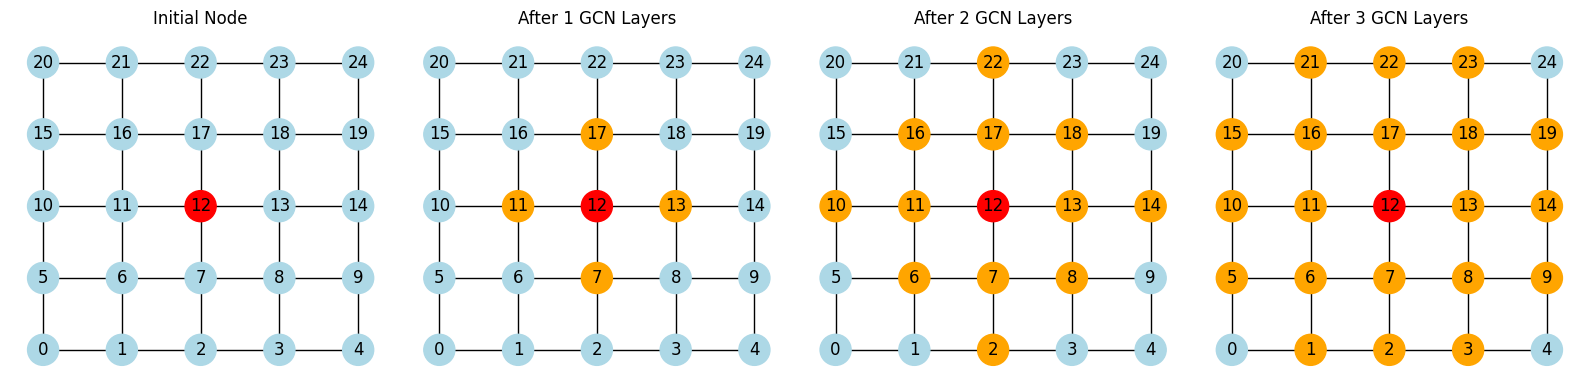


Training model with 1 Layer...
Epoch   5: Train Loss = 4.1095, Val Loss = 4.6878
Epoch  10: Train Loss = 3.8161, Val Loss = 4.2896
Epoch  15: Train Loss = 3.7278, Val Loss = 4.0510
Epoch  20: Train Loss = 3.4872, Val Loss = 3.8200
Epoch  25: Train Loss = 3.2634, Val Loss = 3.5045
Epoch  30: Train Loss = 2.9445, Val Loss = 3.4130
Epoch  35: Train Loss = 2.8010, Val Loss = 2.9771
Epoch  40: Train Loss = 2.7240, Val Loss = 2.8187
Epoch  45: Train Loss = 2.4264, Val Loss = 3.1452
Epoch  50: Train Loss = 2.2796, Val Loss = 2.4351

Training model with 2 Layers...
Epoch   5: Train Loss = 4.2869, Val Loss = 4.7282
Epoch  10: Train Loss = 3.8602, Val Loss = 4.3495
Epoch  15: Train Loss = 3.6995, Val Loss = 4.1670
Epoch  20: Train Loss = 3.4343, Val Loss = 3.7539
Epoch  25: Train Loss = 3.0976, Val Loss = 3.3782
Epoch  30: Train Loss = 2.8614, Val Loss = 4.2481
Epoch  35: Train Loss = 2.7420, Val Loss = 3.0065
Epoch  40: Train Loss = 2.5409, Val Loss = 2.7795
Epoch  45: Train Loss = 2.3568, Val

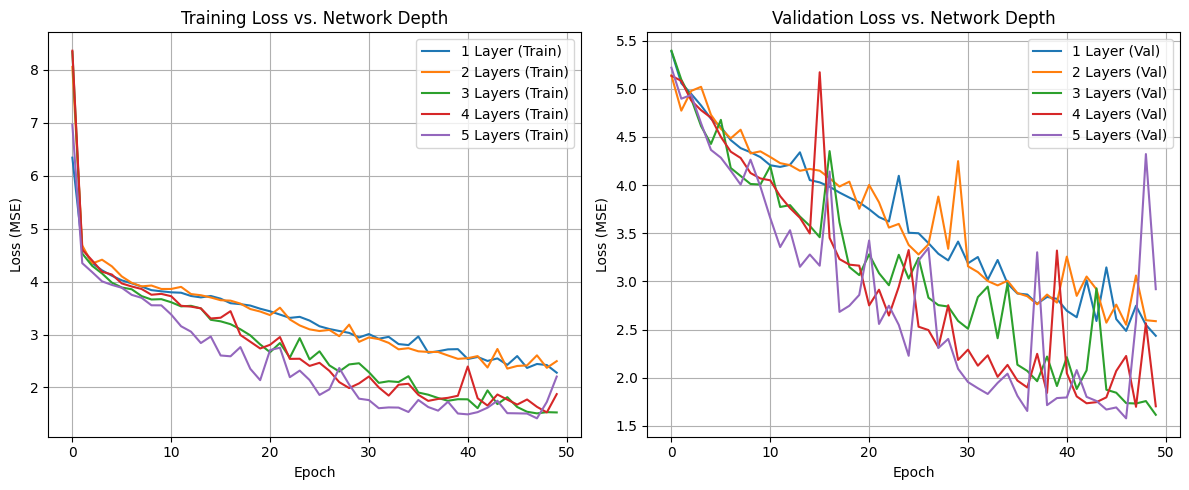

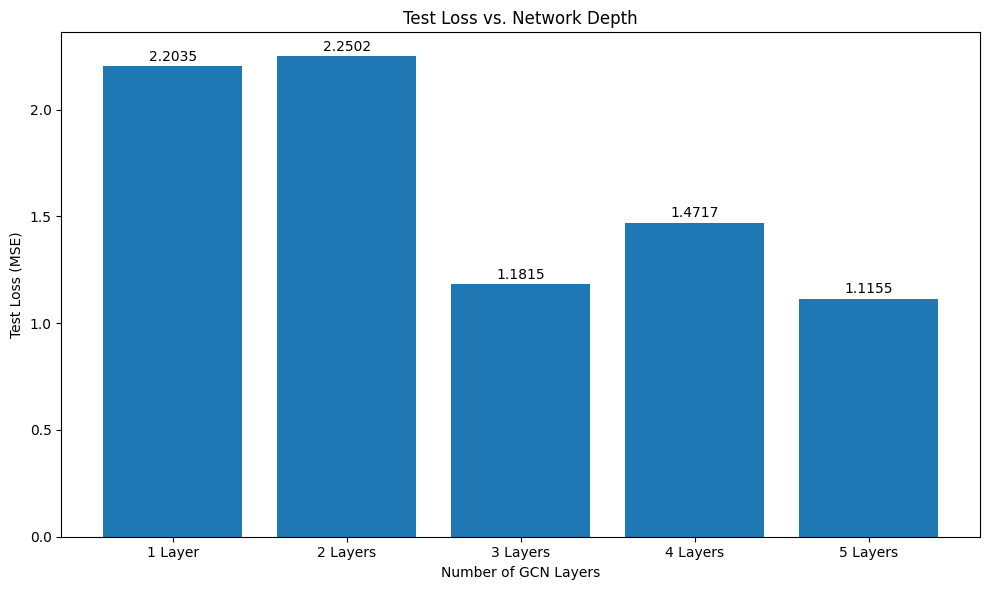

In [ ]:
class VariableDepthGCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers):
        super(VariableDepthGCN, self).__init__()

        self.num_layers = num_layers

        # Input layer
        self.conv1 = GCNConv(in_channels, hidden_channels)

        # Hidden layers
        self.convs = nn.ModuleList([GCNConv(hidden_channels, hidden_channels) for _ in range(num_layers - 1)])

        # Output layers
        self.lin1 = nn.Linear(hidden_channels, hidden_channels)
        self.lin2 = nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index, batch):
        # First GCN layer
        x = F.relu(self.conv1(x, edge_index))

        # Additional GCN layers
        for i in range(self.num_layers - 1):
            x = F.relu(self.convs[i](x, edge_index))

        # Global pooling
        x = global_mean_pool(x, batch)

        # MLP for final prediction
        x = F.relu(self.lin1(x))
        x = self.lin2(x)

        return x

def visualize_receptive_field(num_layers):
    """Visualize how the receptive field grows with network depth"""
    # Create a simple grid graph for visualization
    G = nx.grid_2d_graph(5, 5)

    # Convert to 0-indexed integer nodes
    G = nx.convert_node_labels_to_integers(G)

    # Set positions
    pos = {i: (i % 5, i // 5) for i in range(25)}

    # Create figure
    fig, axes = plt.subplots(1, num_layers + 1, figsize=(4 * (num_layers + 1), 4))

    # Central node
    central_node = 12  # Middle of the grid

    # Drawing the initial graph with the central node highlighted
    ax = axes[0]
    nodes = nx.draw_networkx_nodes(G, pos, node_color=['red' if n == central_node else 'lightblue' for n in G.nodes()],
                                 node_size=500, ax=ax)
    edges = nx.draw_networkx_edges(G, pos, ax=ax)
    labels = nx.draw_networkx_labels(G, pos, ax=ax)
    ax.set_title("Initial Node")
    ax.axis('off')

    # Draw receptive field for each layer
    for layer in range(1, num_layers + 1):
        ax = axes[layer]

        # Compute nodes in the receptive field after 'layer' hops
        receptive_field = {central_node}
        current_boundary = {central_node}

        for _ in range(layer):
            new_boundary = set()
            for node in current_boundary:
                new_boundary.update(G.neighbors(node))
            receptive_field.update(new_boundary)
            current_boundary = new_boundary

        # Color nodes based on whether they're in the receptive field
        node_colors = ['red' if n == central_node else
                      'orange' if n in receptive_field and n != central_node else
                      'lightblue' for n in G.nodes()]

        nodes = nx.draw_networkx_nodes(G, pos, node_color=node_colors,
                                     node_size=500, ax=ax)
        edges = nx.draw_networkx_edges(G, pos, ax=ax)
        labels = nx.draw_networkx_labels(G, pos, ax=ax)
        ax.set_title(f"After {layer} GCN Layers")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize how the receptive field grows with depth
visualize_receptive_field(num_layers=3)

# Compare models with different depths
def compare_network_depths():
    # Get input dimension
    sample = dataset[0]
    in_channels = sample.x.shape[1]

    # Common parameters
    hidden_channels = 64
    out_channels = 1  # Regression task
    lr = 0.001
    weight_decay = 5e-4
    epochs = 50
    criterion = nn.MSELoss()

    # Initialize models with different depths
    models = {
        '1 Layer': VariableDepthGCN(in_channels, hidden_channels, out_channels, num_layers=1).to(device),
        '2 Layers': VariableDepthGCN(in_channels, hidden_channels, out_channels, num_layers=2).to(device),
        '3 Layers': VariableDepthGCN(in_channels, hidden_channels, out_channels, num_layers=3).to(device),
        '4 Layers': VariableDepthGCN(in_channels, hidden_channels, out_channels, num_layers=4).to(device),
        '5 Layers': VariableDepthGCN(in_channels, hidden_channels, out_channels, num_layers=5).to(device),
    }

    # Train and evaluate each model
    results = {}

    for name, model in models.items():
        print(f"\nTraining model with {name}...")
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        results[name] = train_and_evaluate(model, optimizer, criterion, train_loader, val_loader, test_loader, epochs)

    return results

# Run the comparison
depth_results = compare_network_depths()

# Visualize training curves
plt.figure(figsize=(12, 5))

# Plot training loss
plt.subplot(1, 2, 1)
for name, result in depth_results.items():
    plt.plot(result['train_losses'], label=f"{name} (Train)")
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training Loss vs. Network Depth')
plt.legend()
plt.grid(True)

# Plot validation loss
plt.subplot(1, 2, 2)
for name, result in depth_results.items():
    plt.plot(result['val_losses'], label=f"{name} (Val)")
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Validation Loss vs. Network Depth')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Visualize test performance
names = list(depth_results.keys())
test_losses = [result['test_loss'] for result in depth_results.values()]

plt.figure(figsize=(10, 6))
bars = plt.bar(names, test_losses)
plt.xlabel('Number of GCN Layers')
plt.ylabel('Test Loss (MSE)')
plt.title('Test Loss vs. Network Depth')

# Add value labels on the bars
for bar, val in zip(bars, test_losses):
    plt.text(bar.get_x() + bar.get_width()/2.0, bar.get_height() + 0.01, f'{val:.4f}',
            ha='center', va='bottom')

plt.tight_layout()
plt.show()

# The Oversmoothing Problem in Deep GCNs

As more GCN layers are added, node features tend to converge to similar values, causing:

1. **Loss of Discriminative Power**: Nodes become indistinguishable
2. **Gradient Vanishing**: Training becomes more difficult
3. **Decreased Performance**: Model accuracy drops after certain depth

This phenomenon, called "oversmoothing," explains why GCNs often don't benefit
from extra depth like CNNs or Transformers.

# Solutions for Oversmoothing:

1. **Skip Connections**: Allow information to flow directly from earlier layers
2. **Normalization Techniques**: Layer norm, batch norm, etc.
3. **Residual Connections**: Help preserve feature diversity
4. **Attention Mechanisms**: Focus on important neighbors (like GAT)

Next, let's investigate how skip connections can mitigate the oversmoothing problem

## 9. Understanding and Implementing Skip Connections <a name="skip-connection"></a>

Skip (or residual) connections allow information to flow directly from earlier layers to later layers, bypassing intermediate operations. Let's explore how they can improve GCN performance:

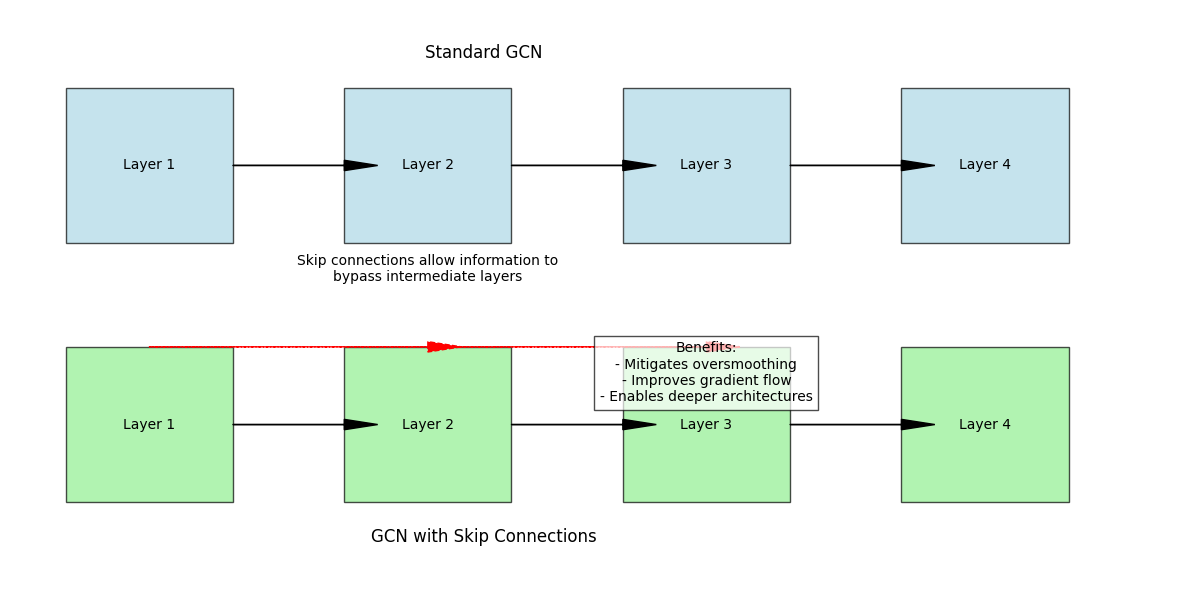


Training model: 2 Layers (No Skip)...
Epoch   5: Train Loss = 4.0476, Val Loss = 4.5693
Epoch  10: Train Loss = 3.8362, Val Loss = 4.2436
Epoch  15: Train Loss = 3.6418, Val Loss = 3.9164
Epoch  20: Train Loss = 3.2963, Val Loss = 3.5816
Epoch  25: Train Loss = 3.0613, Val Loss = 3.2559
Epoch  30: Train Loss = 2.8784, Val Loss = 3.0227
Epoch  35: Train Loss = 2.6812, Val Loss = 2.9176
Epoch  40: Train Loss = 2.4235, Val Loss = 2.9096
Epoch  45: Train Loss = 2.2268, Val Loss = 2.4415
Epoch  50: Train Loss = 1.9551, Val Loss = 2.2949

Training model: 2 Layers (With Skip)...
Epoch   5: Train Loss = 4.0911, Val Loss = 4.6564
Epoch  10: Train Loss = 3.7801, Val Loss = 4.2408
Epoch  15: Train Loss = 3.7902, Val Loss = 4.0940
Epoch  20: Train Loss = 3.6215, Val Loss = 3.9758
Epoch  25: Train Loss = 3.5008, Val Loss = 3.8375
Epoch  30: Train Loss = 3.3055, Val Loss = 3.7180
Epoch  35: Train Loss = 3.1301, Val Loss = 3.4143
Epoch  40: Train Loss = 2.9745, Val Loss = 3.2066
Epoch  45: Train Los

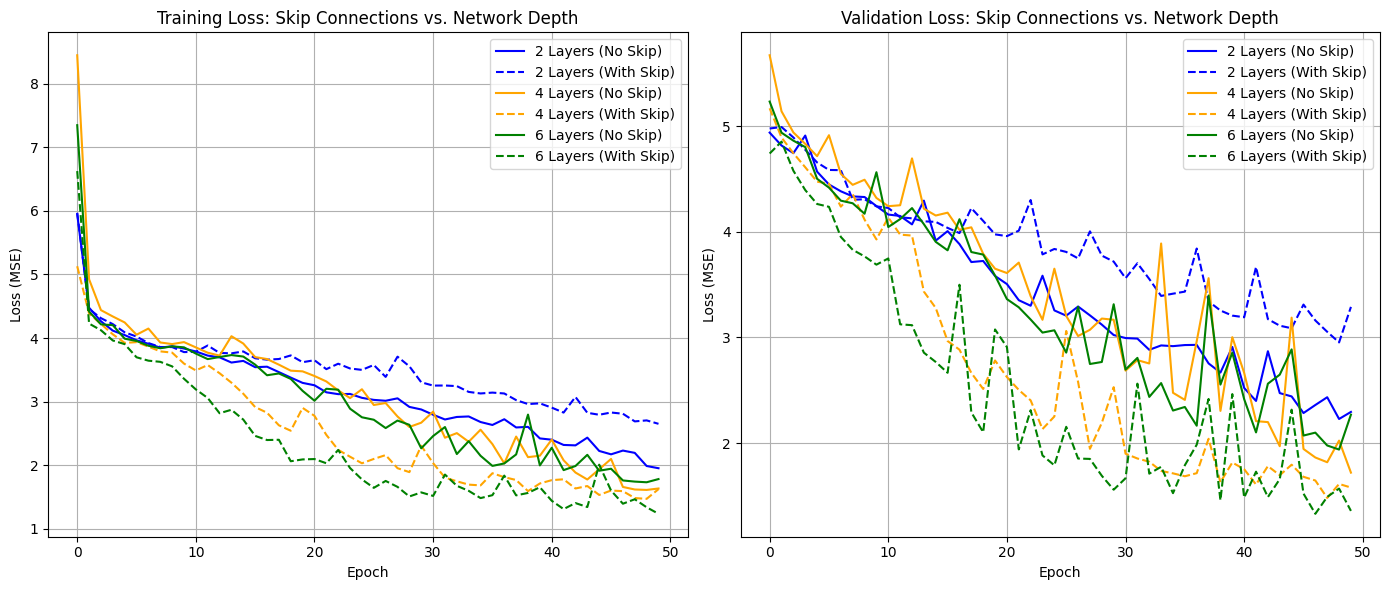

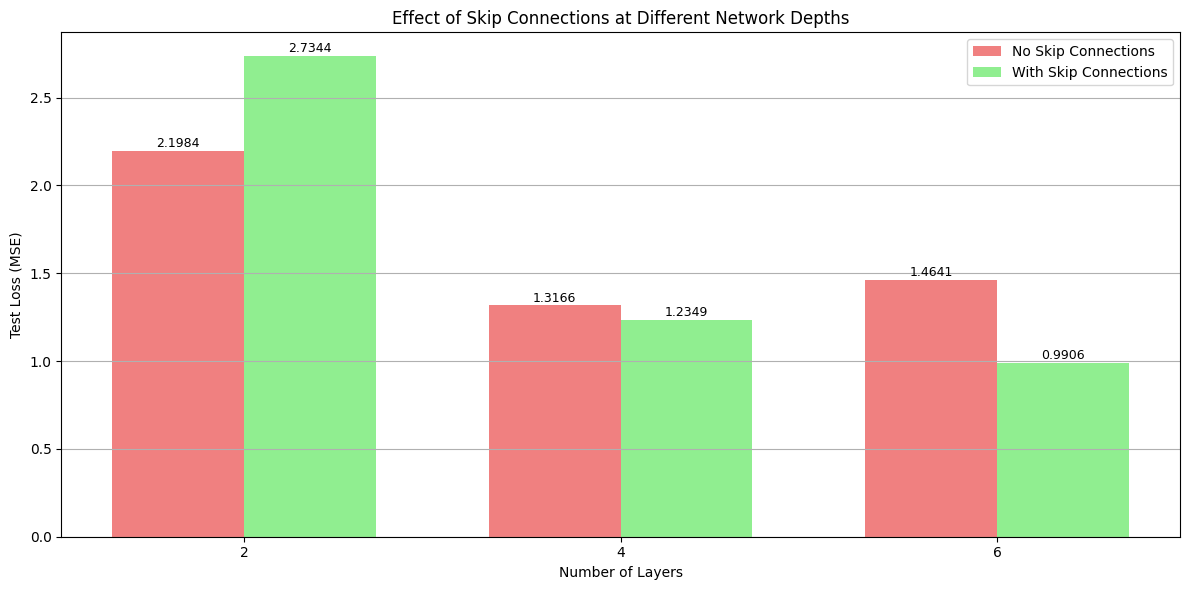

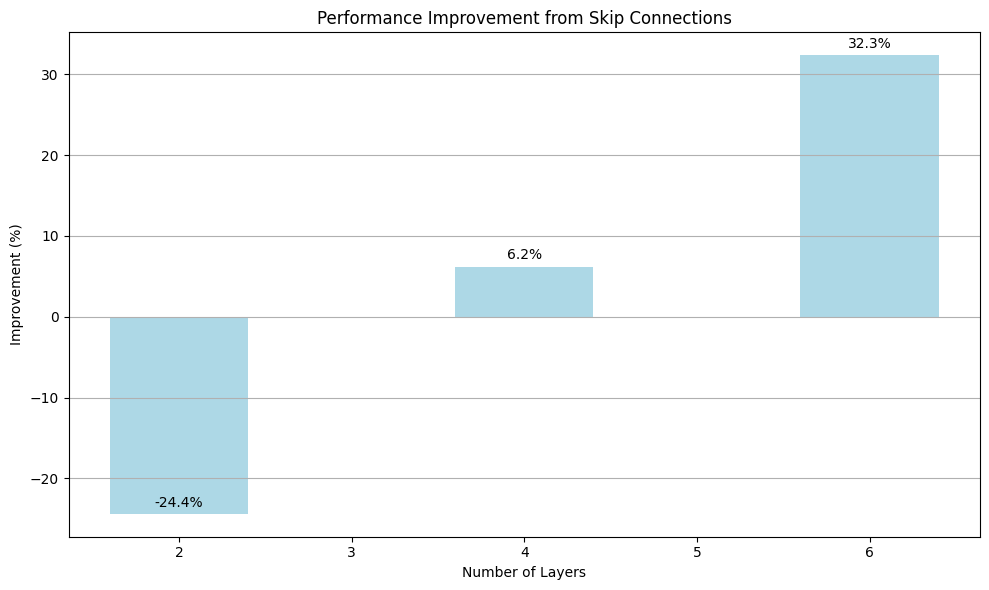

In [ ]:
class GCNWithSkipConnections(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers=3, use_skip=True):
        super(GCNWithSkipConnections, self).__init__()

        self.num_layers = num_layers
        self.use_skip = use_skip

        # Input layer
        self.conv1 = GCNConv(in_channels, hidden_channels)

        # Hidden layers
        self.convs = nn.ModuleList([GCNConv(hidden_channels, hidden_channels) for _ in range(num_layers - 1)])

        # Output layers
        self.lin1 = nn.Linear(hidden_channels, hidden_channels)
        self.lin2 = nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index, batch):
        # First GCN layer
        x = F.relu(self.conv1(x, edge_index))

        # Additional GCN layers with potential skip connections
        for i in range(self.num_layers - 1):
            if self.use_skip:
                # Store the input to this layer
                identity = x
                # Apply GCN and activation
                x = F.relu(self.convs[i](x, edge_index))
                # Add skip connection (residual)
                x = x + identity
            else:
                # Standard GCN without skip
                x = F.relu(self.convs[i](x, edge_index))

        # Global pooling
        x = global_mean_pool(x, batch)

        # MLP for final prediction
        x = F.relu(self.lin1(x))
        x = self.lin2(x)

        return x

def visualize_skip_connections():
    """Create a visual explanation of how skip connections work"""
    fig, ax = plt.subplots(figsize=(12, 6))

    # Regular GCN Layers
    offset = 0
    rect_width = 1.5
    rect_height = 3
    spacing = 2.5

    # Draw boxes for standard GCN
    y_pos = 2.5
    for i in range(4):
        rect = plt.Rectangle((offset + i*spacing, y_pos), rect_width, rect_height,
                            facecolor='lightblue', edgecolor='black', alpha=0.7)
        ax.add_patch(rect)
        ax.text(offset + i*spacing + rect_width/2, y_pos + rect_height/2, f"Layer {i+1}",
              ha='center', va='center', fontsize=10)

    # Draw arrows connecting layers
    for i in range(3):
        ax.arrow(offset + i*spacing + rect_width, y_pos + rect_height/2,
               spacing - rect_width, 0, head_width=0.2, head_length=0.3,
               fc='black', ec='black')

    # Label for standard GCN
    ax.text(offset + 1.5*spacing, y_pos + rect_height + 0.5, "Standard GCN",
          ha='center', va='bottom', fontsize=12)

    # Draw boxes for GCN with skip connections
    y_pos = -2.5
    for i in range(4):
        rect = plt.Rectangle((offset + i*spacing, y_pos), rect_width, rect_height,
                            facecolor='lightgreen', edgecolor='black', alpha=0.7)
        ax.add_patch(rect)
        ax.text(offset + i*spacing + rect_width/2, y_pos + rect_height/2, f"Layer {i+1}",
              ha='center', va='center', fontsize=10)

    # Draw regular arrows connecting layers
    for i in range(3):
        ax.arrow(offset + i*spacing + rect_width, y_pos + rect_height/2,
               spacing - rect_width, 0, head_width=0.2, head_length=0.3,
               fc='black', ec='black')

    # Draw skip connection arrows
    for i in range(2):
        ax.arrow(offset + i*spacing + rect_width/2, y_pos + rect_height,
               spacing, 0, head_width=0.2, head_length=0.3,
               fc='red', ec='red', linestyle='--')

    # Label for GCN with skip connections
    ax.text(offset + 1.5*spacing, y_pos - 0.5, "GCN with Skip Connections",
          ha='center', va='top', fontsize=12)

    # Add explanatory labels
    ax.text(offset + 1*spacing + rect_width/2, y_pos + rect_height + 1.5,
          "Skip connections allow information to\nbypass intermediate layers",
          ha='center', va='center', fontsize=10)

    ax.text(offset + 2*spacing + rect_width/2, 0,
          "Benefits:\n- Mitigates oversmoothing\n- Improves gradient flow\n- Enables deeper architectures",
          ha='center', va='center', fontsize=10, bbox=dict(facecolor='white', alpha=0.7))

    ax.set_xlim(-0.5, 10)
    ax.set_ylim(-4, 7)
    ax.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize skip connections
visualize_skip_connections()

# Compare models with and without skip connections at different depths
def compare_skip_connections():
    # Get input dimension
    sample = dataset[0]
    in_channels = sample.x.shape[1]

    # Common parameters
    hidden_channels = 64
    out_channels = 1  # Regression task
    lr = 0.001
    weight_decay = 5e-4
    epochs = 50
    criterion = nn.MSELoss()

    # Initialize models with different depths and skip connection settings
    models = {
        '2 Layers (No Skip)': GCNWithSkipConnections(in_channels, hidden_channels, out_channels, num_layers=2, use_skip=False).to(device),
        '2 Layers (With Skip)': GCNWithSkipConnections(in_channels, hidden_channels, out_channels, num_layers=2, use_skip=True).to(device),
        '4 Layers (No Skip)': GCNWithSkipConnections(in_channels, hidden_channels, out_channels, num_layers=4, use_skip=False).to(device),
        '4 Layers (With Skip)': GCNWithSkipConnections(in_channels, hidden_channels, out_channels, num_layers=4, use_skip=True).to(device),
        '6 Layers (No Skip)': GCNWithSkipConnections(in_channels, hidden_channels, out_channels, num_layers=6, use_skip=False).to(device),
        '6 Layers (With Skip)': GCNWithSkipConnections(in_channels, hidden_channels, out_channels, num_layers=6, use_skip=True).to(device),
    }

    # Train and evaluate each model
    results = {}

    for name, model in models.items():
        print(f"\nTraining model: {name}...")
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        results[name] = train_and_evaluate(model, optimizer, criterion, train_loader, val_loader, test_loader, epochs)

    return results

# Run the comparison
skip_results = compare_skip_connections()

# Visualize training curves
plt.figure(figsize=(14, 6))

# Plot training loss
plt.subplot(1, 2, 1)
colors = ['blue', 'orange', 'green']
linestyles = ['-', '--']

for i, depth in enumerate([2, 4, 6]):
    for j, skip in enumerate([False, True]):
        name = f"{depth} Layers ({'With' if skip else 'No'} Skip)"
        result = skip_results[name]
        plt.plot(result['train_losses'], color=colors[i], linestyle=linestyles[j],
                label=name)

plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training Loss: Skip Connections vs. Network Depth')
plt.legend()
plt.grid(True)

# Plot validation loss
plt.subplot(1, 2, 2)
for i, depth in enumerate([2, 4, 6]):
    for j, skip in enumerate([False, True]):
        name = f"{depth} Layers ({'With' if skip else 'No'} Skip)"
        result = skip_results[name]
        plt.plot(result['val_losses'], color=colors[i], linestyle=linestyles[j],
                label=name)

plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Validation Loss: Skip Connections vs. Network Depth')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Visualize test performance
names = list(skip_results.keys())
test_losses = [result['test_loss'] for result in skip_results.values()]

# Group data for better visualization
plt.figure(figsize=(12, 6))

# Extract data in structured form
depths = [2, 4, 6]
no_skip_losses = [skip_results[f"{d} Layers (No Skip)"]["test_loss"] for d in depths]
with_skip_losses = [skip_results[f"{d} Layers (With Skip)"]["test_loss"] for d in depths]

# Set up bar positions
bar_width = 0.35
x = np.arange(len(depths))

# Create grouped bars
plt.bar(x - bar_width/2, no_skip_losses, bar_width, label='No Skip Connections', color='lightcoral')
plt.bar(x + bar_width/2, with_skip_losses, bar_width, label='With Skip Connections', color='lightgreen')

# Add labels and customize
plt.xlabel('Number of Layers')
plt.ylabel('Test Loss (MSE)')
plt.title('Effect of Skip Connections at Different Network Depths')
plt.xticks(x, depths)
plt.legend()
plt.grid(True, axis='y')

# Add value labels
for i, v in enumerate(no_skip_losses):
    plt.text(i - bar_width/2, v + 0.005, f'{v:.4f}', ha='center', va='bottom', fontsize=9)
for i, v in enumerate(with_skip_losses):
    plt.text(i + bar_width/2, v + 0.005, f'{v:.4f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Analyze the performance improvement from skip connections
improvement = [(no_skip - with_skip) / no_skip * 100 for no_skip, with_skip in zip(no_skip_losses, with_skip_losses)]

plt.figure(figsize=(10, 6))
plt.bar(depths, improvement, color='lightblue')
plt.xlabel('Number of Layers')
plt.ylabel('Improvement (%)')
plt.title('Performance Improvement from Skip Connections')
plt.grid(True, axis='y')

# Add value labels
for i, v in enumerate(improvement):
    plt.text(depths[i], v + 0.5, f'{v:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## 10. Visualizing Node Feature Learning <a name="node-feature-learning"></a>

Let's now visualize how node features evolve through the GCN layers, with and without skip connections:

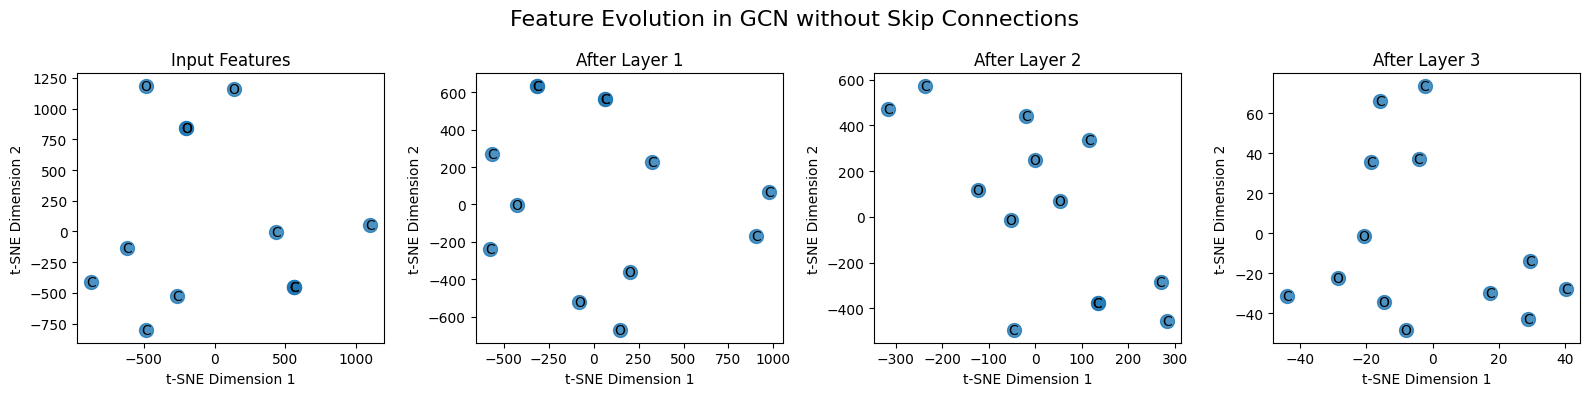

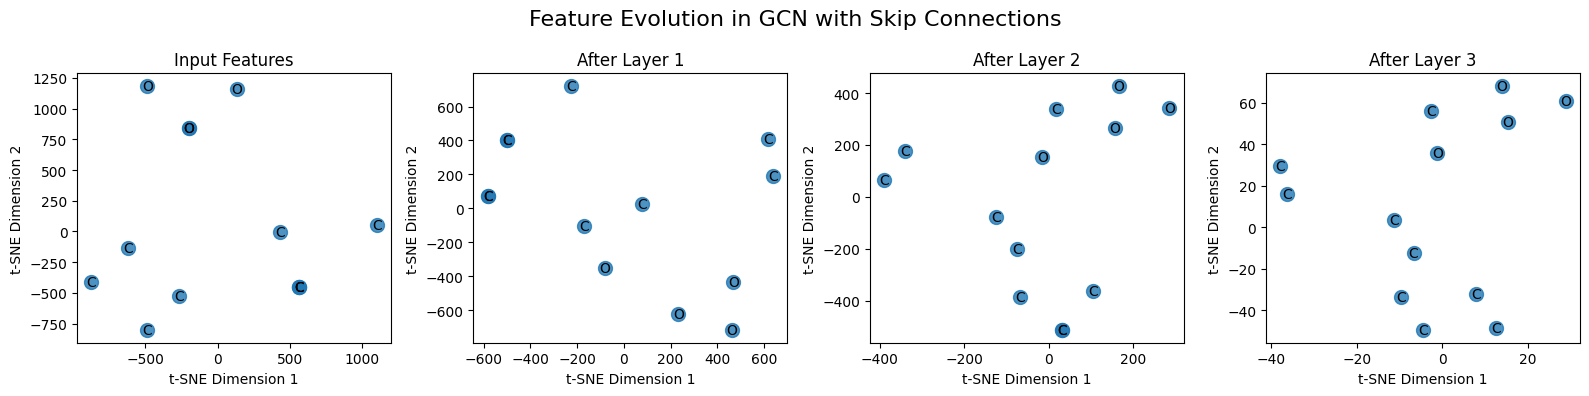

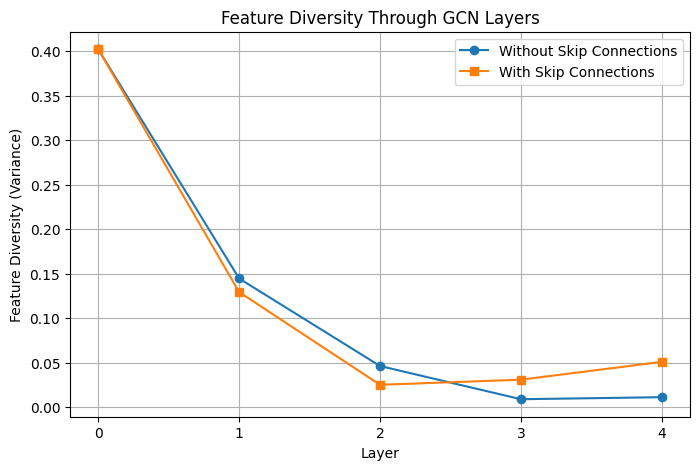

In [ ]:
def visualize_feature_evolution(model, data, smiles, use_skip=False):
    """Visualize how node features are transformed through the GCN layers"""
    model.eval()

    # Create hooks to get intermediate activations
    activations = {}

    def get_activation(name):
        def hook(module, input, output):
            activations[name] = output.detach()
        return hook

    # Register hooks for each layer
    hooks = []
    hooks.append(model.conv1.register_forward_hook(get_activation('conv1')))
    for i, conv in enumerate(model.convs):
        hooks.append(conv.register_forward_hook(get_activation(f'conv{i+2}')))

    # Forward pass
    with torch.no_grad():
        # Move data to the correct device
        data = data.to(device)

        # Create a fake batch index (all zeros since we have only one graph)
        batch = torch.zeros(data.x.size(0), dtype=torch.long, device=device)

        # Forward pass
        _ = model(data.x, data.edge_index, batch)

    # Remove the hooks
    for hook in hooks:
        hook.remove()

    # Get the input features
    input_features = data.x.cpu().numpy()

    # Get activations for each layer
    all_features = [input_features]
    for i in range(len(activations)):
        all_features.append(activations[f'conv{i+1}'].cpu().numpy())

    # Use t-SNE to visualize high-dimensional features
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(5, all_features[i].shape[0]-1))

    # Create molecule for reference
    mol = Chem.MolFromSmiles(smiles)
    atom_symbols = [atom.GetSymbol() for atom in mol.GetAtoms()]

    # Determine how many layers to plot
    num_layers = min(4, len(all_features))

    # Plot the feature evolution
    fig, axes = plt.subplots(1, num_layers, figsize=(4 * num_layers, 4))

    for i in range(num_layers):
        ax = axes[i]

        # Apply t-SNE to reduce dimensions
        if all_features[i].shape[1] > 2:
            features_2d = tsne.fit_transform(all_features[i])
        else:
            features_2d = all_features[i]

        # Plot the features
        scatter = ax.scatter(features_2d[:, 0], features_2d[:, 1], s=100, alpha=0.8)

        # Add atom labels
        for j, symbol in enumerate(atom_symbols):
            ax.text(features_2d[j, 0], features_2d[j, 1], symbol, ha='center', va='center')

        # Set title
        if i == 0:
            ax.set_title('Input Features')
        else:
            ax.set_title(f'After Layer {i}')

        ax.set_xlabel('t-SNE Dimension 1')
        ax.set_ylabel('t-SNE Dimension 2')

    plt.suptitle(f'Feature Evolution in GCN {"with" if use_skip else "without"} Skip Connections', fontsize=16)
    plt.tight_layout()
    plt.show()

    return all_features

# Create and train two small models for visualization
def train_small_model_for_vis(use_skip=False):
    """Train a small model for feature visualization"""
    # Get sample molecule
    smiles = example_molecules["Aspirin"]
    data = mol_to_graph(smiles)

    # Create model
    in_channels = data.x.shape[1]
    hidden_channels = 16
    out_channels = 1
    num_layers = 4

    model = GCNWithSkipConnections(
        in_channels,
        hidden_channels,
        out_channels,
        num_layers=num_layers,
        use_skip=use_skip
    ).to(device)

    # Train briefly (just to get some reasonable parameters)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.MSELoss()

    # Fake target
    target = torch.Tensor([0.5]).to(device)

    model.train()
    for _ in range(50):
        optimizer.zero_grad()
        out = model(data.x.to(device), data.edge_index.to(device), torch.zeros(data.x.size(0), dtype=torch.long, device=device))
        loss = criterion(out, target)
        loss.backward()
        optimizer.step()

    return model, data, smiles

# Get models
no_skip_model, aspirin_data, aspirin_smiles = train_small_model_for_vis(use_skip=False)
skip_model, _, _ = train_small_model_for_vis(use_skip=True)

# Visualize feature evolution
no_skip_features = visualize_feature_evolution(no_skip_model, aspirin_data, aspirin_smiles, use_skip=False)
skip_features = visualize_feature_evolution(skip_model, aspirin_data, aspirin_smiles, use_skip=True)

# Calculate feature diversity through layers
def feature_diversity(features_list):
    """Calculate how diverse the features are at each layer"""
    return [np.var(features, axis=0).mean() for features in features_list]

no_skip_diversity = feature_diversity(no_skip_features)
skip_diversity = feature_diversity(skip_features)

# Plot feature diversity
plt.figure(figsize=(8, 5))
plt.plot(range(len(no_skip_diversity)), no_skip_diversity, 'o-', label='Without Skip Connections')
plt.plot(range(len(skip_diversity)), skip_diversity, 's-', label='With Skip Connections')
plt.xlabel('Layer')
plt.ylabel('Feature Diversity (Variance)')
plt.title('Feature Diversity Through GCN Layers')
plt.xticks(range(len(no_skip_diversity)))
plt.legend()
plt.grid(True)
plt.show()

## 11. Conclusion and Comprehensive Findings <a name="conclusion"></a>

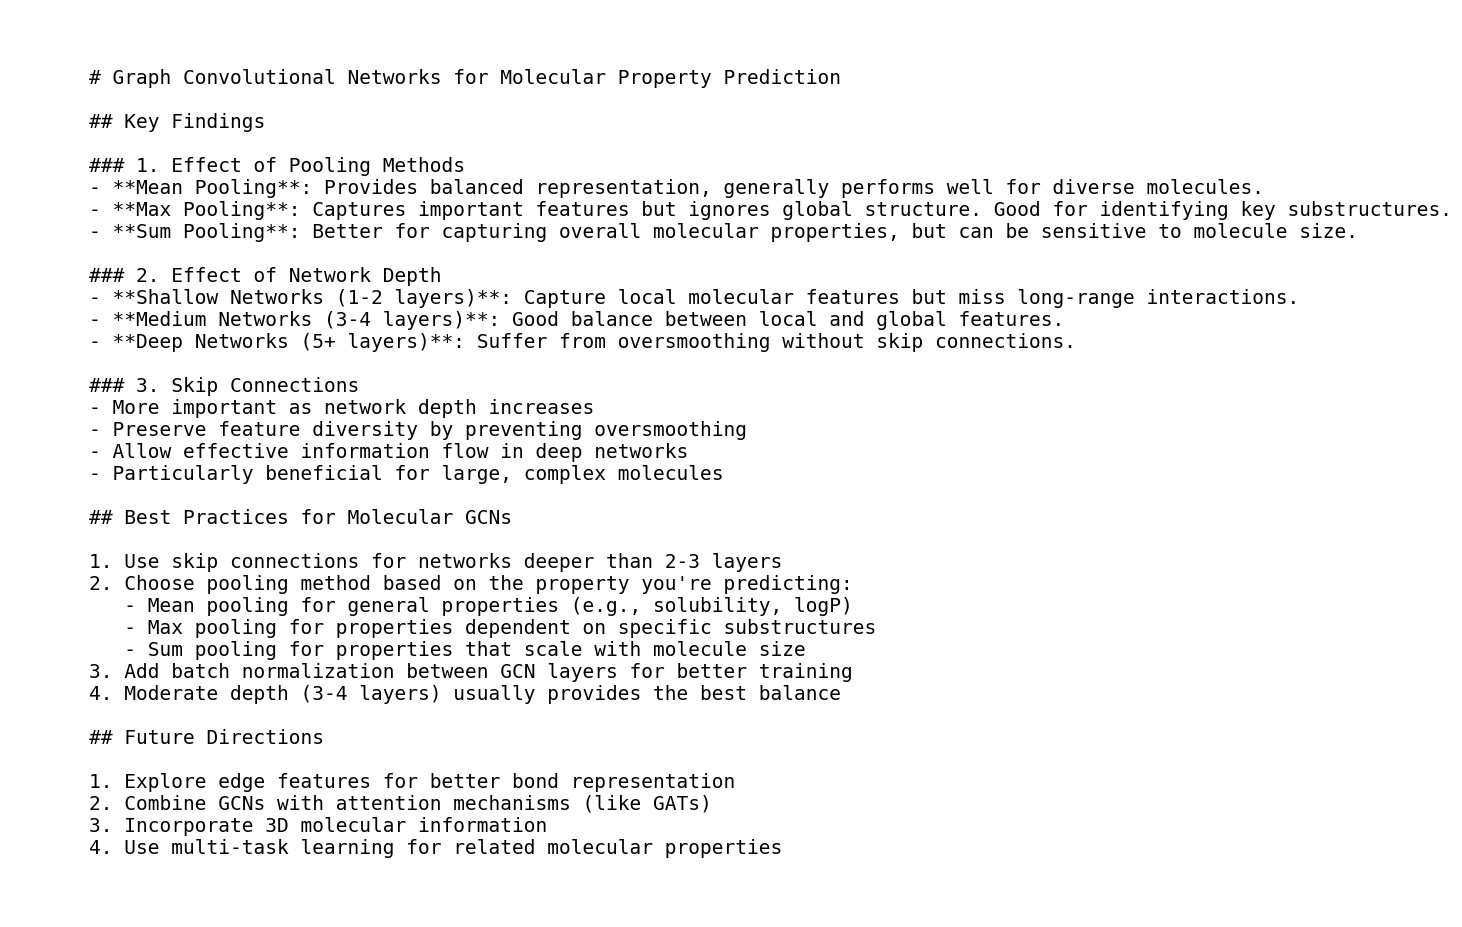

In [ ]:
def summarize_findings():
    """Create a visual summary of our findings about GCNs"""
    plt.figure(figsize=(12, 10))
    text = """
    # Graph Convolutional Networks for Molecular Property Prediction

    ## Key Findings

    ### 1. Effect of Pooling Methods
    - **Mean Pooling**: Provides balanced representation, generally performs well for diverse molecules.
    - **Max Pooling**: Captures important features but ignores global structure. Good for identifying key substructures.
    - **Sum Pooling**: Better for capturing overall molecular properties, but can be sensitive to molecule size.

    ### 2. Effect of Network Depth
    - **Shallow Networks (1-2 layers)**: Capture local molecular features but miss long-range interactions.
    - **Medium Networks (3-4 layers)**: Good balance between local and global features.
    - **Deep Networks (5+ layers)**: Suffer from oversmoothing without skip connections.

    ### 3. Skip Connections
    - More important as network depth increases
    - Preserve feature diversity by preventing oversmoothing
    - Allow effective information flow in deep networks
    - Particularly beneficial for large, complex molecules

    ## Best Practices for Molecular GCNs

    1. Use skip connections for networks deeper than 2-3 layers
    2. Choose pooling method based on the property you're predicting:
       - Mean pooling for general properties (e.g., solubility, logP)
       - Max pooling for properties dependent on specific substructures
       - Sum pooling for properties that scale with molecule size
    3. Add batch normalization between GCN layers for better training
    4. Moderate depth (3-4 layers) usually provides the best balance

    ## Future Directions

    1. Explore edge features for better bond representation
    2. Combine GCNs with attention mechanisms (like GATs)
    3. Incorporate 3D molecular information
    4. Use multi-task learning for related molecular properties
    """
    plt.text(0.05, 0.5, text, fontsize=14, fontfamily='monospace',
            verticalalignment='center', horizontalalignment='left')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Summarize our findings
summarize_findings()

## 12. Additional Resources and References <a name="resources"></a>

Here are some important papers and resources for further exploration of GCNs in chemistry:

1. **Original GCN paper**: Kipf & Welling, "Semi-Supervised Classification with Graph Convolutional Networks" (2017)
2. **Chemical GCNs**: Yang et al., "Analyzing Learned Molecular Representations for Property Prediction" (2019)
3. **Oversmoothing**: Li et al., "Deeper Insights into Graph Convolutional Networks for Semi-Supervised Learning" (2018)
4. **Skip Connections**: Xu et al., "Representation Learning on Graphs with Jumping Knowledge Networks" (2018)

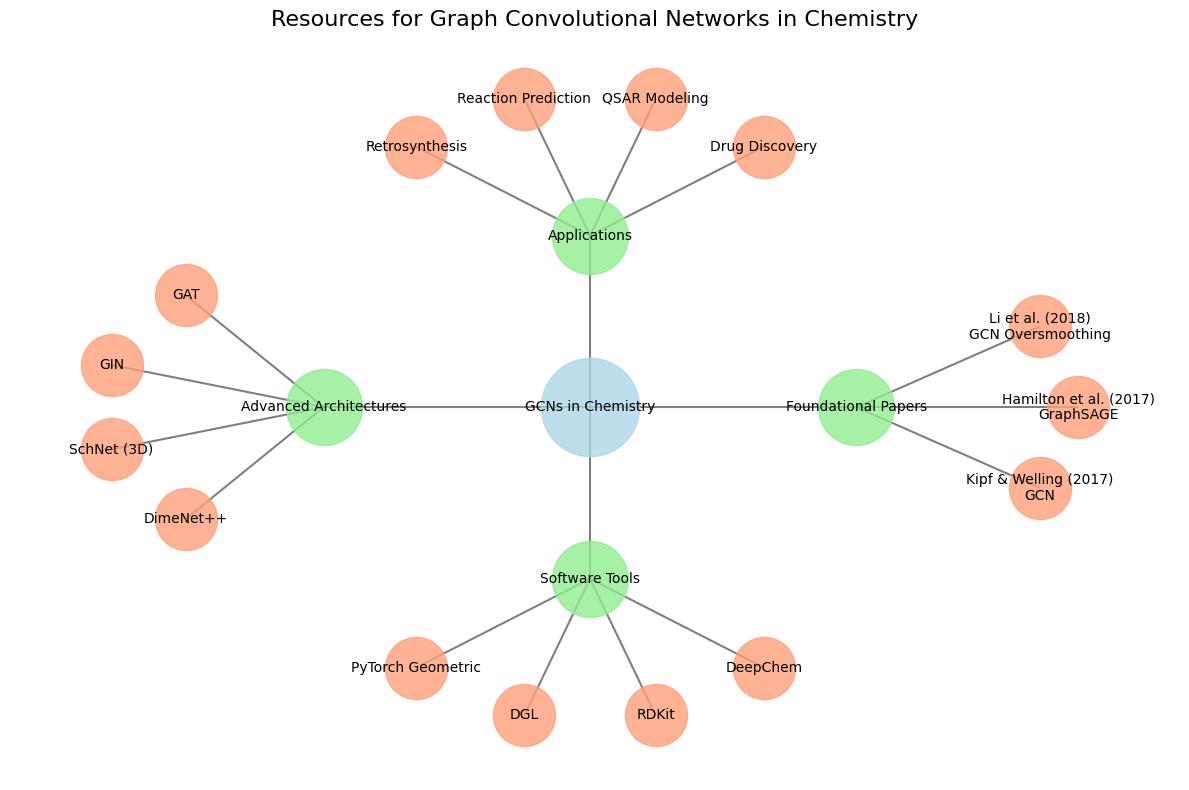

This concludes our tutorial on Graph Convolutional Networks for molecular property prediction!


In [ ]:
def create_resources_visualization():
    """Create a visual guide to GCN resources"""
    fig, ax = plt.subplots(figsize=(12, 8))

    # Create a mind map style visualization
    G = nx.Graph()

    # Add nodes for different categories
    G.add_node("GCNs in Chemistry", pos=(0, 0))

    # Add resource categories
    categories = ["Foundational Papers", "Applications", "Advanced Architectures", "Software Tools"]
    for i, category in enumerate(categories):
        angle = 2 * np.pi * i / len(categories)
        x = 3 * np.cos(angle)
        y = 3 * np.sin(angle)
        G.add_node(category, pos=(x, y))
        G.add_edge("GCNs in Chemistry", category)

    # Add specific resources for each category
    resources = {
        "Foundational Papers": [
            "Kipf & Welling (2017)\nGCN",
            "Hamilton et al. (2017)\nGraphSAGE",
            "Li et al. (2018)\nGCN Oversmoothing"
        ],
        "Applications": [
            "Drug Discovery",
            "QSAR Modeling",
            "Reaction Prediction",
            "Retrosynthesis"
        ],
        "Advanced Architectures": [
            "GAT",
            "GIN",
            "SchNet (3D)",
            "DimeNet++"
        ],
        "Software Tools": [
            "PyTorch Geometric",
            "DGL",
            "RDKit",
            "DeepChem"
        ]
    }

    # Add resource nodes
    for category, res_list in resources.items():
        cat_idx = categories.index(category)
        cat_angle = 2 * np.pi * cat_idx / len(categories)
        cat_x = 3 * np.cos(cat_angle)
        cat_y = 3 * np.sin(cat_angle)

        for i, resource in enumerate(res_list):
            # Calculate position in a small arc around the category
            angle_offset = (i - (len(res_list) - 1) / 2) * 0.6
            dist = 2.5
            x = cat_x + dist * np.cos(cat_angle + angle_offset)
            y = cat_y + dist * np.sin(cat_angle + angle_offset)
            G.add_node(resource, pos=(x, y))
            G.add_edge(category, resource)

    # Get positions
    pos = nx.get_node_attributes(G, 'pos')

    # Draw the graph
    nx.draw_networkx_nodes(G, pos,
                         nodelist=["GCNs in Chemistry"],
                         node_size=5000,
                         node_color='lightblue',
                         alpha=0.8)

    nx.draw_networkx_nodes(G, pos,
                         nodelist=categories,
                         node_size=3000,
                         node_color='lightgreen',
                         alpha=0.8)

    # Create a flattened list of all resources
    all_resources = [res for res_list in resources.values() for res in res_list]

    nx.draw_networkx_nodes(G, pos,
                         nodelist=all_resources,
                         node_size=2000,
                         node_color='lightsalmon',
                         alpha=0.8)

    # Draw edges
    nx.draw_networkx_edges(G, pos, width=1.5, alpha=0.5)

    # Draw labels
    nx.draw_networkx_labels(G, pos,
                          font_size=10,
                          font_family='sans-serif')

    plt.title("Resources for Graph Convolutional Networks in Chemistry", fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Show resources
create_resources_visualization()

print("This concludes our tutorial on Graph Convolutional Networks for molecular property prediction!")

This completes our comprehensive tutorial on Graph Convolutional Networks for chemists and pharmacists, with special focus on pooling methods, network depth, and skip connections.